## Семинар 1 "Полносвязные нейронные сети"

ФИО: 

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.normal(0, 0.1, (input_size + 1, output_size))
        self.dLdw = 0
        self.X = 0
        
        return
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size d
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        
        return np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.weights)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        dLdx = np.dot(dLdy, self.weights[:len(self.weights) - 1].T)  
        self.dLdw = np.dot(np.vstack((self.X.T, np.ones(self.X.shape[0]))), dLdy)
        
        return dLdx
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        self.weights = self.weights + self.dLdw * learning_rate

### Часть 2: Сигмоида

In [3]:
class Sigmoid:
    def __init__(self):
        self.X = np.array([])
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size d
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        
        self.X = X
        
        return 1.0 / (1.0 + np.exp(-1 * X))
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        
        m = np.exp(self.X)
        #print(dLdy.shape, self.X.shape)
    
        return dLdy * (m / (m + 1.0)**2)
    
    def step(self, learning_rate):
        pass


# RELU

In [4]:
class RELU:
    def __init__(self):
        self.X = np.array([])
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size d
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        m = np.array([[max(X[i][j], 0) for j in range(len(X[0]))] for i in range(len(self.X))])
        
        return m
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        
        #print(dLdy.shape, self.X.shape)
        
        
        return dLdy * (self.X > 0)
    
    def step(self, learning_rate):
        pass

In [5]:
relu = RELU()
relu.forward(np.array([[6,1], [1,-4]]))
relu.backward([2,1])


array([[2, 1],
       [2, 0]])

# ELU

In [6]:
class ELU:
    def __init__(self):
        self.X = np.array([])
        pass
    
    def forward(self, X):
        self.X = X
        return  X * (X > 0) + 0.5 * (np.exp(X * (self.X <= 0)) - 1) * (self.X <= 0)


    
    
    def backward(self, dLdy):
        return dLdy * (1.0 * (self.X > 0) + (0.5 * (np.exp(self.X * (self.X <= 0)) - 1) + 0.5) * (self.X <= 0))
    
    
    def step(self, learning_rate):
        pass

In [9]:
elu = ELU()
a = np.array([[1,-1],[2,4]])
elu.forward(np.array([[1,-1],[2,4]]))
elu.backward(np.array([1,1]))
#(a > 0)


array([[ 1.        ,  0.18393972],
       [ 1.        ,  1.        ]])

### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [10]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        self.X = np.array([])
        self.y = np.array([])
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        
        self.X = X
        self.y = y
        
        def ch(T):
            return np.exp(T - T.max()).sum()
        
        t_1 = np.array(list(map(ch, X)))
        #t_1 = t_1.sum()
        t_2 = []
        for i in range(len(X)):
            t_2.append(X[i][self.y[i]] - X[i].max())
            
        
        
        return ((np.array(t_2) - np.log(t_1))/len(X)).sum()
    
    def backward(self):
        '''
        Note that here 
        dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        res = np.exp(self.X)
        r = np.array([res[i].sum() for i in range(len(self.X))])
        
        for i in range(len(self.X)):
            res[i] /= -r[i]
        for i in range(len(self.X)):
            
            res[i][self.y[i]] += 1.0
        
        return res

In [11]:
nll = NLLLoss()

nll.forward(np.array([[0, 1],[1,1],[2,1]]), np.array([1,1,1]))


-0.77322351853213034

In [12]:
nll.backward()

array([[-0.26894142,  0.26894142],
       [-0.5       ,  0.5       ],
       [-0.73105858,  0.73105858]])

### Часть 4, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [66]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.modules = modules
        pass
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        res = X
        for module in self.modules:
            res = module.forward(res)
        return res
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        d = dLdy
        for module in self.modules[::-1]:
            #print(d.shape)
            d = module.backward(d)
    
    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)

### Часть 5, обучение на простых данных

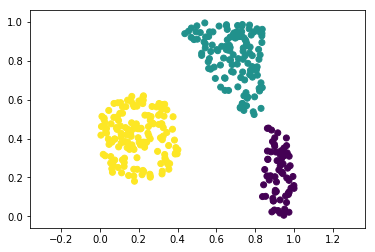

In [67]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [68]:
### YOUR CODE HERE:

In [69]:
#m = [Linear(2, 10), RELU(), Linear(10, 10), RELU(), Linear(10, 3)]
m = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]

nll = NLLLoss()
nn = NeuralNetwork(m)

In [70]:
#atl = np.array([0 for i in range(10)])
import math
from math import exp, log
tl = 0
flag = []

for j in range(500):
    tl = 0
    ind = 0
    res = nn.forward(X)
    loss = nll.forward(res, y)
    nn.backward(nll.backward())
    nn.step(0.01)
    flag.append(loss)
    


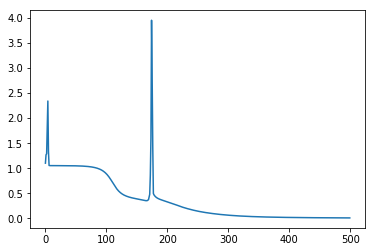

In [73]:
plt.plot(range(500), -1*np.array(flag))


In [74]:
colors = np.array([0 for i in range(len(y))])

In [75]:
colors = []
res = nn.forward(X)
res = np.exp(res) / np.exp(res).sum()
colors.append([res[i].argmax() for i in range(len(y))])

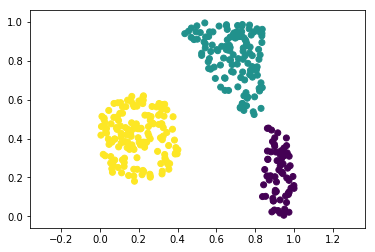

In [76]:
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.axis('equal')
plt.show()

In [77]:
x = np.linspace(-0.2, 1.2, 100)
y = np.linspace(0,1,100)
xv, yv = np.meshgrid(x, y)


In [78]:
gip = []
for i in range(len(xv)):
    for j in range(len(yv)):
        gip.append([xv[i][j],yv[i][j]])
final = np.array(gip)
final

array([[-0.2       ,  0.        ],
       [-0.18585859,  0.        ],
       [-0.17171717,  0.        ],
       ..., 
       [ 1.17171717,  1.        ],
       [ 1.18585859,  1.        ],
       [ 1.2       ,  1.        ]])

In [79]:
result = nn.forward(final)
colors_final = np.array([result[i].argmax() for i in range(len(y)**2)])
colors_final

array([2, 2, 2, ..., 0, 0, 0])

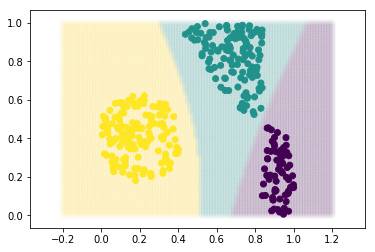

In [80]:
plt.scatter(final[:,0], final[:,1], c = colors_final, alpha=0.03)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.axis('equal')
plt.show()